In [32]:
#!python -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126
#!python -m pip install scikit-learn
!python -m pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 5.6 MB/s eta 0:00:02
   ----------- ---------------------------- 2.4/8.1 MB 5.8 MB/s eta 0:00:01
   --------------- ------------------------ 3.1/8.1 MB 5.3 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/8.1 MB 4.8 MB/s eta 0:00:01
   ----------------------- ---------------- 4.7/8.1 MB 4.5 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 4.6 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.1 MB 4.6 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 4.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.7 MB/s  0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------------ --------------------- 1.0/2.3 MB 5.6 MB/s 

In [1]:
import zipfile
from PIL import Image
import torch
from torchvision import transforms
from io import BytesIO
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from collections import defaultdict



device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("GPU is", "available" if device else "NOT AVAILABLE")

# Caminho para o arquivo ZIP
zip_path1 = 'cops_db.zip'

# Transforms para redimensionar e converter para tensor
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Converte para [C x H x W]
])

# Lista para armazenar os tensores
image_in_tensors = []
image_out_tensors = []
image_out_class = []


# Abre o ZIP e processa as imagens diretamente
def loadImages_crops(zip_path, max):
    count = 0
    label_map = {}  # Mapeia nome da pasta para um label numérico
    image_in_tensors = []
    image_out_class = []

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Extrai o nome da pasta (classe)
                parts = file_name.split('/')
                if len(parts) < 2:
                    continue  # Ignora arquivos fora das pastas de classe
                folder_name = parts[1]
                #print(folder_name)    

                # Atribui um label único para cada pasta
                if folder_name not in label_map:
                    label_map[folder_name] = len(label_map)
                label = label_map[folder_name]

                #print(label)                 

                with zip_ref.open(file_name) as file:
                    image = Image.open(BytesIO(file.read())).convert('RGB')
                    tensor = transform(image)  # Shape: [3, 256, 256]
                    image_in_tensors.append(tensor)
                    image_out_class.append([label])

                count += 1
                if count % 1000 == 0:
                    print(count)

                if count >= max:
                    break
    
    print("NClasses: ",len(label_map))
    return image_in_tensors, image_out_class


# Empilha os tensores em um batch
image_in_tensors,image_out_class = loadImages_crops(zip_path1,5000)


print(f'Total de imagens carregadas: {len(image_in_tensors)}')

class_groups = defaultdict(list)
for img, lbl in zip(image_in_tensors, image_out_class):
    class_groups[int(lbl[0])].append(img)

train_images = []
train_labels = []
test_images = []
test_labels = []

for label, images in class_groups.items():
    images = np.array(images)
    n = len(images)
    indices = np.random.permutation(n)
    split = int(n * 0.7)

    train_idx = indices[:split]
    test_idx = indices[split:]

    for i in train_idx:
        train_images.append(images[i])
        classes_obj = np.zeros(30)
        classes_obj[label] = 1
        train_labels.append(classes_obj)

    for i in test_idx:
        test_images.append(images[i])
        classes_obj = np.zeros(30)
        classes_obj[label] = 1
        test_labels.append(classes_obj)

# Empacotar como tensores
train_images = [torch.tensor(img) if not isinstance(img, torch.Tensor) else img for img in train_images]

t_xt = torch.stack(train_images).to(device)
t_yt = torch.tensor(train_labels, dtype=torch.float32).to(device)

test_images = [torch.tensor(img) if not isinstance(img, torch.Tensor) else img for img in test_images]
t_xv = torch.stack(test_images).to(device)
t_yv = torch.tensor(test_labels, dtype=torch.float32).to(device)


dataset = TensorDataset(t_xt, t_yt)
#batch_tensor = torch.stack(image_in_tensors)  # Shape: [N, 3, 256, 256]


print(f'Shape do batch: {t_xt.shape}')
print(f'Shape dos rótulos: {t_yt.shape}')



GPU is available
NClasses:  30
Total de imagens carregadas: 829
Shape do batch: torch.Size([569, 3, 128, 128])
Shape dos rótulos: torch.Size([569, 30])


C:\Users\Denni\AppData\Local\Temp\ipykernel_15284\2423188447.py:111: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  t_yt = torch.tensor(train_labels, dtype=torch.float32).to(device)


In [46]:
import torch;
import torch.nn as nn

class RedeCnnBirdNotBird(nn.Module):
    def __init__(self):
        super(RedeCnnBirdNotBird, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, stride=1) # 124x124
        self.conv2 = nn.Conv2d(6, 12, 5, stride=1) # 120x120
        self.poll1 = nn.MaxPool2d(2,2) # 60 x 60
        self.conv3 = nn.Conv2d(12, 24, 5, stride=1) # 56 x 56
        self.conv4 = nn.Conv2d(24, 48, 5, stride=1) # 52 x 52
        self.poll2 = nn.MaxPool2d(2,2) # 26x26
        self.conv5 = nn.Conv2d(48, 96, 11, stride=1) # 16 x 16
        self.poll3 = nn.MaxPool2d(2,2) # 8x8
        self.conv6 = nn.Conv2d(96, 256, 5, stride=1) # 4 x 4
        
        self.linear1 = nn.Linear(4096,1024)
        self.linear2 = nn.Linear(1024,30)
        #self.linear3 = nn.Linear(164,164)
        #self.linear4 = nn.Linear(512,1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.poll1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.poll2(x)
        x = self.conv5(x)
        x = self.poll3(x)
        x = self.conv6(x)
        #print("x poll1: ",x.size())
        
        x = torch.flatten(x, start_dim=1)
        
        #print("x flatten: ",x.size())
        
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        
        #x = torch.relu(self.linear1(x))
        #x = torch.relu(self.linear2(x))
        #x = torch.tanh(self.linear3(x))
        #x = torch.relu(self.linear4(x))
        return x

In [51]:
import time

def train(cnn,dataset, epochs=10,lrp=0.000001):
    opt = torch.optim.Adam(cnn.parameters(),lr=lrp)#0.00001  #0.0000001

    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True
    )

    for epoch in range(epochs):
        totalloss = 0
        batch = 0
        start_time = time.time()
        opt.zero_grad()

        for inputs, targets in train_loader:
            
            #inputs = x[:, :insize]    
            #targets = x[:, insize:] 
            #x = x.to(device) # GPU
            x_hat = cnn(inputs)
            #print(inputs.size()," ",targets.size()," ",x_hat.size())
            loss = ((targets - x_hat)**2).sum()

            loss.backward(retain_graph=True)
            totalloss+=loss
            batch+=1
 
            opt.step()
            opt.zero_grad()
            #print("step: ")

        end_time = time.time()
        print(epoch," Total Loss: ",(totalloss/len(dataset))," time ",(end_time-start_time))
        #if epoch%250==0:
        #    torch.save(cnn, "backup_training_gam_v02.pth")
    return cnn


In [58]:
import os

cnn = RedeCnnBirdNotBird().to(device)

if os.path.exists("cnn_v1.pth"):
   cnn = torch.load("cnn_v1.pth", weights_only=False)
   print("CARREGOU MODELO: ","cnn_v1.pth")

cnn = train(cnn, dataset,epochs=100,lrp=0.000001)

torch.save(cnn, "cnn_v1.pth")





CARREGOU MODELO:  cnn_v1.pth
0  Total Loss:  tensor(0.2594, device='cuda:0', grad_fn=<DivBackward0>)  time  1.9955601692199707
1  Total Loss:  tensor(0.2600, device='cuda:0', grad_fn=<DivBackward0>)  time  2.170285701751709
2  Total Loss:  tensor(0.2594, device='cuda:0', grad_fn=<DivBackward0>)  time  2.327406167984009
3  Total Loss:  tensor(0.2603, device='cuda:0', grad_fn=<DivBackward0>)  time  2.8624653816223145
4  Total Loss:  tensor(0.2606, device='cuda:0', grad_fn=<DivBackward0>)  time  3.04552960395813
5  Total Loss:  tensor(0.2585, device='cuda:0', grad_fn=<DivBackward0>)  time  2.093616485595703
6  Total Loss:  tensor(0.2590, device='cuda:0', grad_fn=<DivBackward0>)  time  2.850194215774536
7  Total Loss:  tensor(0.2596, device='cuda:0', grad_fn=<DivBackward0>)  time  2.033787965774536
8  Total Loss:  tensor(0.2581, device='cuda:0', grad_fn=<DivBackward0>)  time  2.5168676376342773
9  Total Loss:  tensor(0.2578, device='cuda:0', grad_fn=<DivBackward0>)  time  2.069915056228637

In [53]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report



def calculaMetricas(dataset,cnn):

    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True
    )

    all_preds = []
    all_targets = []


    for inputs, targets in train_loader:
        y_pre = cnn(inputs)
        
        _,preds = torch.max(y_pre, 1)  # pega a classe com maior probabilidade
        _,target = torch.max(targets, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)
    #print(cm)
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    print(classification_report(all_targets, all_preds))




------------------- Treinamento ---------------------------------


c:\Users\Denni\OneDrive - UNIVALI\DISCIPLINAS\Mestrado\work\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Denni\OneDrive - UNIVALI\DISCIPLINAS\Mestrado\work\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Denni\OneDrive - UNIVALI\DISCIPLINAS\Mestrado\work\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

              precision    recall  f1-score   support

           0       0.16      1.00      0.28        22
           1       1.00      0.90      0.95        20
           2       0.95      0.90      0.93        21
           3       0.00      0.00      0.00        16
           4       0.94      0.89      0.92        19
           5       1.00      1.00      1.00        21
           6       1.00      0.96      0.98        27
           7       1.00      1.00      1.00        23
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00        21
          10       0.93      0.93      0.93        15
          11       1.00      0.94      0.97        16
          12       0.95      1.00      0.98        21
          13       0.00      0.00      0.00        17
          14       1.00      0.86      0.93        22
          15       0.84      0.94      0.89        17
          16       0.95      1.00      0.98        21
          17       1.00    

c:\Users\Denni\OneDrive - UNIVALI\DISCIPLINAS\Mestrado\work\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Denni\OneDrive - UNIVALI\DISCIPLINAS\Mestrado\work\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Denni\OneDrive - UNIVALI\DISCIPLINAS\Mestrado\work\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

              precision    recall  f1-score   support

           0       0.07      0.30      0.11        10
           1       0.43      0.33      0.38         9
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         9
           5       0.29      0.44      0.35         9
           6       0.33      0.25      0.29        12
           7       0.09      0.10      0.10        10
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00        10
          10       0.20      0.14      0.17         7
          11       0.50      0.43      0.46         7
          12       0.13      0.22      0.17         9
          13       0.00      0.00      0.00         8
          14       0.33      0.10      0.15        10
          15       0.23      0.38      0.29         8
          16       0.31      0.44      0.36         9
          17       0.75    

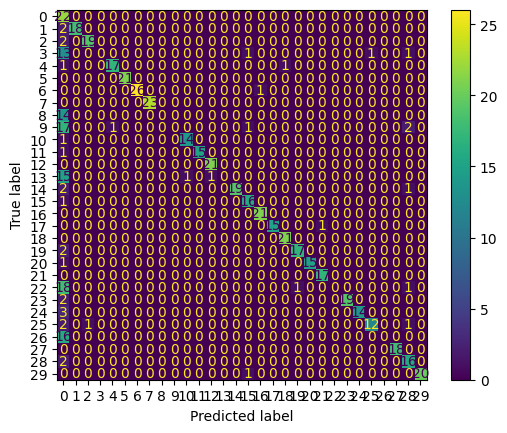

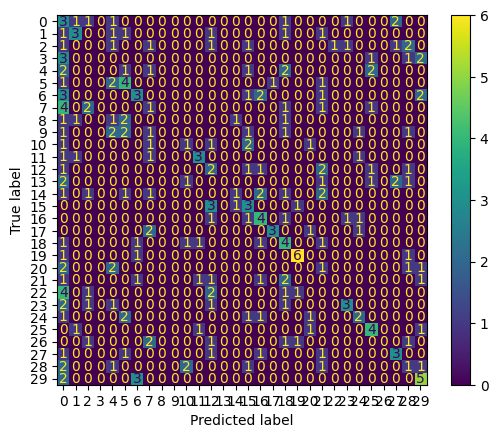

In [59]:
print("------------------- Treinamento ---------------------------------")
calculaMetricas(dataset,cnn)
print("------------------- TESTE ---------------------------------")
t_xtb = t_xv.to(device)
t_ytb = t_yv.to(device)
datasetb = TensorDataset(t_xtb, t_ytb)
calculaMetricas(datasetb,cnn)